In [1]:
#Tensorflow < 3.11 (Last supported windows-native version)
#Requires py 3.9

#Import dependencies
import os

#Import external dependencies
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow.keras import layers
from IPython import display
from matplotlib import pyplot as plt
import numpy as np

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
parent = os.path.join(os.path.dirname(os.getcwd()), 'data')
weto_path = os.path.join(parent, 'weto', 'train')

In [3]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=weto_path,
    #label_mode = "binary",
    batch_size=32,
    validation_split=0.2,
    seed=0,
    shuffle = True,
    output_sequence_length=48000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

train_ds.element_spec

Found 1345 files belonging to 2 classes.
Using 1076 files for training.
Using 269 files for validation.

label names: ['negative' 'positive']


(TensorSpec(shape=(None, 48000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [4]:
#Dataset only contains one channel
#Remove the extra axis

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [5]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(32, 48000)
(32,)


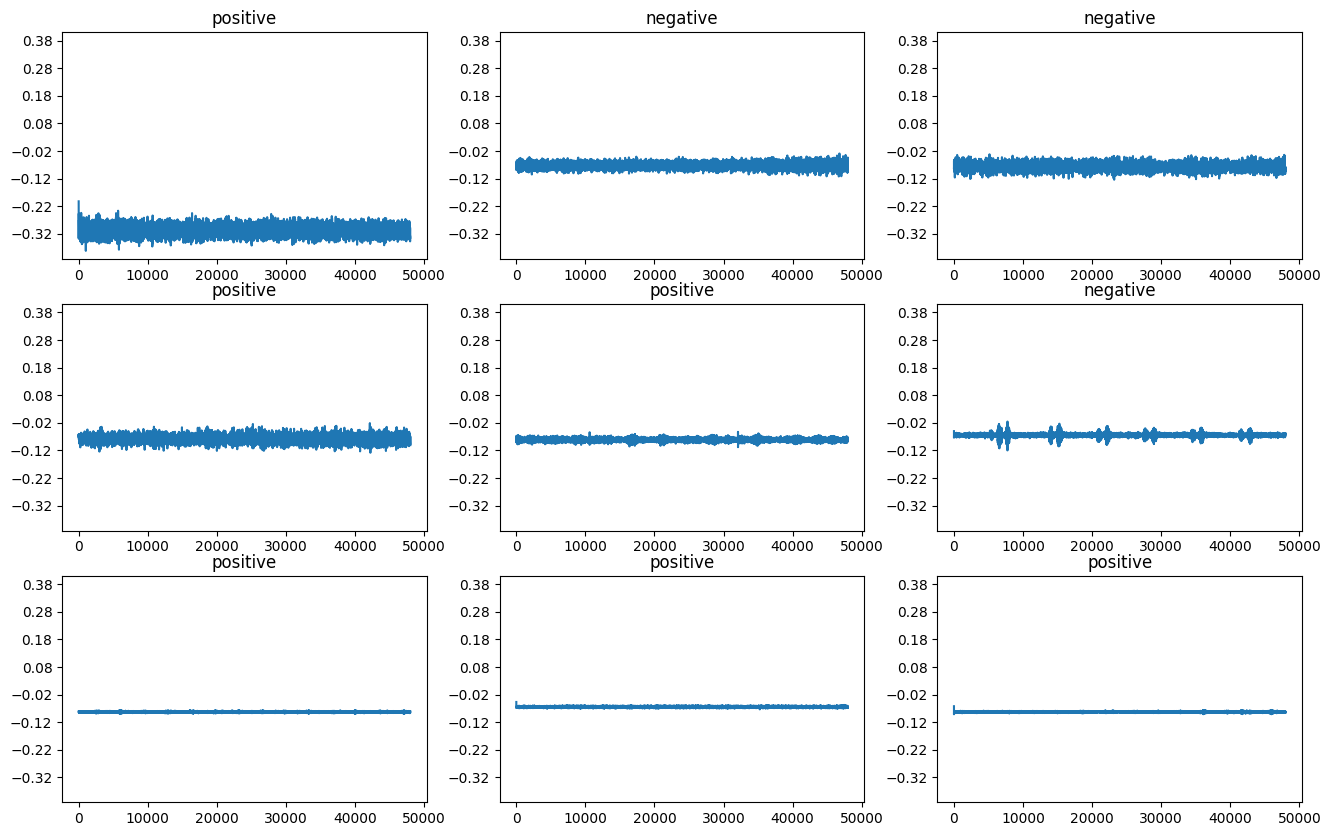

In [6]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-0.42, 0.42, 0.1))
  plt.ylim([-0.41, 0.41])

In [7]:
#Convert waveform to spectrogram

def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=512, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [8]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: positive
Waveform shape: (48000,)
Spectrogram shape: (372, 257, 1)
Audio playback


Label: negative
Waveform shape: (48000,)
Spectrogram shape: (372, 257, 1)
Audio playback


Label: negative
Waveform shape: (48000,)
Spectrogram shape: (372, 257, 1)
Audio playback


In [9]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

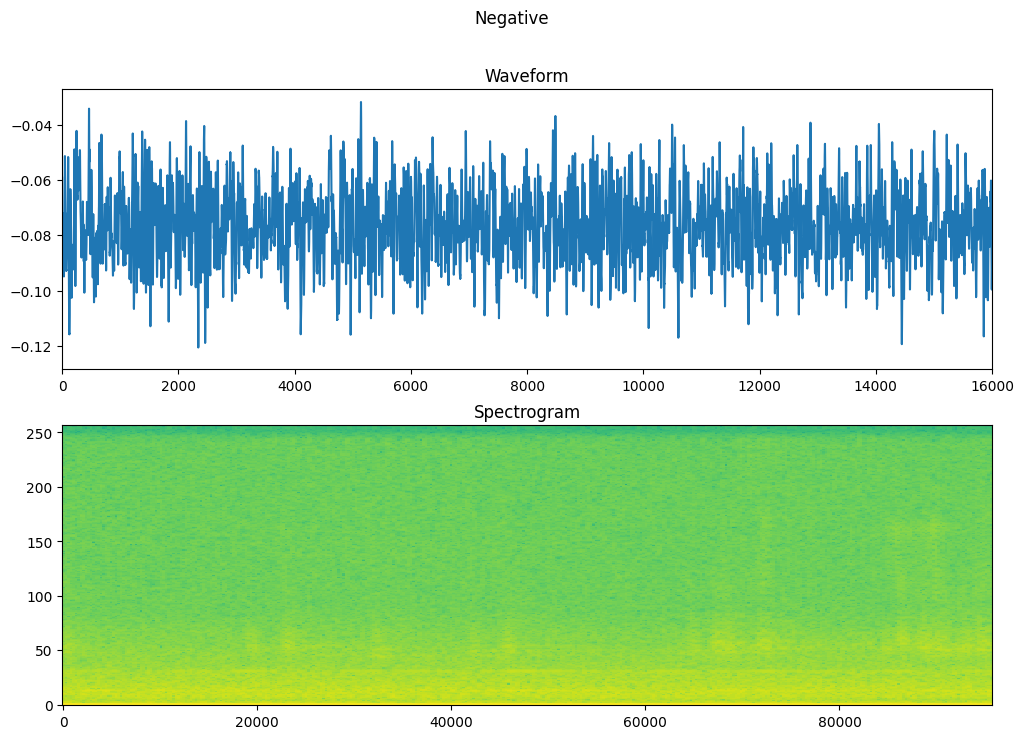

In [10]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [38]:
#Make spectrogram datasets

def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [14]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

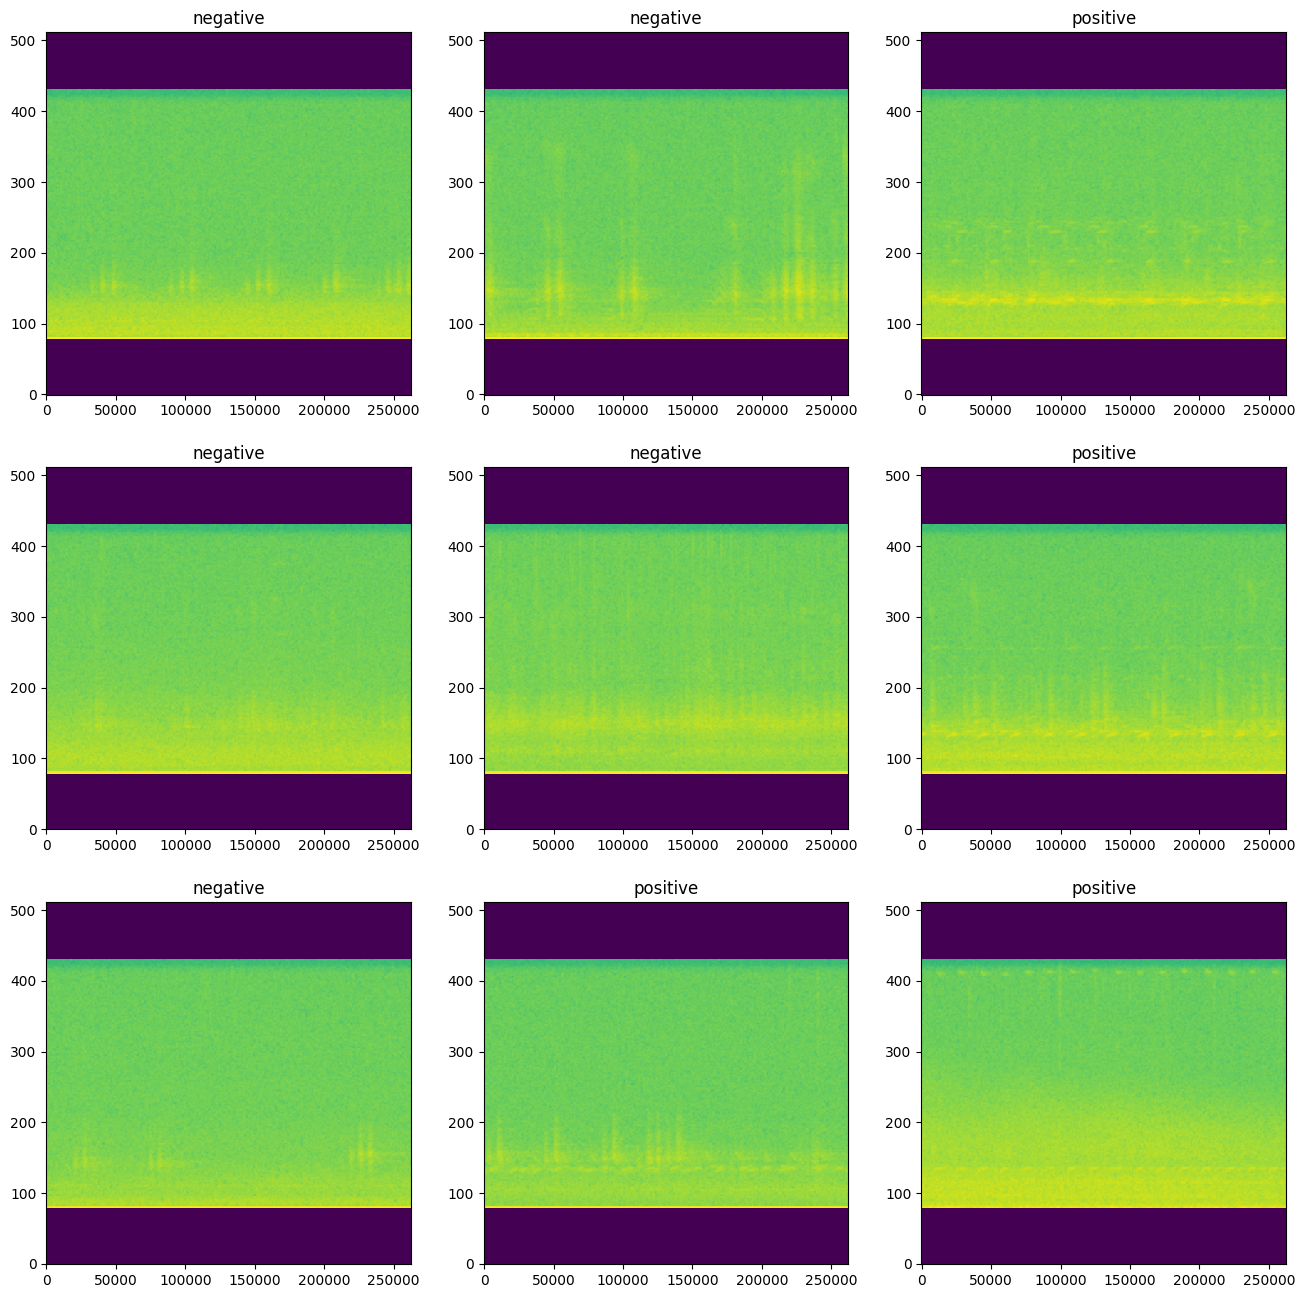

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])
plt.show()

In [42]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(1100).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [44]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

Input shape: (372, 257, 1)


In [ ]:
STEPS_PER_EPOCH = 57

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)
import numpy as np
step = np.linspace(0,3000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [46]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [47]:
rn34 = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[372, 257, 1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    rn34.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

rn34.add(tf.keras.layers.GlobalAvgPool2D())
rn34.add(tf.keras.layers.Flatten())
rn34.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [48]:
tf.keras.backend.clear_session()

rn34.compile(optimizer = get_optimizer(), loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
rn34.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 186, 129, 64)      3136      
                                                                 
 batch_normalization (BatchN  (None, 186, 129, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 186, 129, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 93, 65, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 93, 65, 64)       74240     
 )                                                               
                                                        

In [49]:
rn34_hist = rn34.fit(train_spectrogram_ds, 
                 epochs=200,
                 verbose = 1, 
                 shuffle = True, 
                 validation_data = val_spectrogram_ds)

Epoch 1/200
 1/34 [..............................] - ETA: 18:58 - loss: 0.6747 - recall: 0.2222 - precision: 0.5000

In [ ]:
pd.DataFrame(rn34_hist.history).plot(
    figsize=(8, 5), xlim=[0, 200], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

### Other Models

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras import regularizers

In [14]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="swish", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[1497, 65, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128, strides = (2,2)),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256, strides = (2,2)),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [48]:
tf.keras.backend.clear_session()

model.compile(optimizer = get_optimizer(), loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1497, 65, 64)      3200      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 748, 32, 64)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 374, 16, 128)      73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 374, 16, 128)      147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 187, 8, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 94, 4, 256)        295168    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 94, 4, 256)       

In [ ]:
hist = model.fit(train, 
                 epochs=30,
                 verbose = 1, 
                 shuffle = True, 
                 validation_data = test)

In [ ]:
pd.DataFrame(hist.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

## GoogLeNet

In [53]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import concatenate

In [95]:

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [102]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (747, 129, 1))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  #X1 = Dense(5, activation = 'softmax')(X1) #Not for Binary Classifier -GH
  X1 = Dense(1, activation = 'sigmoid')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  #X2 = Dense(1000, activation = 'softmax')(X2) #Not for Binary Classifier -GH
  X2 = Dense(1, activation = 'sigmoid')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  #X = Dense(1000, activation = 'softmax')(X) #Not for Binary Classifier -GH
  X = Dense(1, activation = 'sigmoid')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [103]:
tf.keras.backend.clear_session()

google_model = GoogLeNet()

google_model.compile(optimizer = get_optimizer(), loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
google_model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 747, 129, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 371, 62, 64)  3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 185, 30, 64)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 185, 30, 64)  4160        max_pooling2d[0][0]              
__________________________________________________________________________________________

In [ ]:
google_hist = google_model.fit(train, 
                 epochs=30,
                 verbose = 1, 
                 shuffle = True, 
                 validation_data = test)

## SE-ResNet

In [20]:
from tensorflow.keras.layers import GlobalAvgPool2D, Dense
from functools import partial
from tensorflow.keras.activations import sigmoid


In [21]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
    
class SeBlock(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.main_layers = [
            GlobalAvgPool2D(),
            Dense(units=units/16, activation="relu", kernel_initializer="he_normal"),
            Dense(units=units),
        ]


    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        return sigmoid(Z)

In [32]:
test = SeBlock(5)
test2 = ResidualUnit(20)
[layer for layer in test.main_layers + test2.main_layers]

 <function tensorflow.python.keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0)>,

: 

In [23]:
se_rn34 = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[747, 129, 1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    se_rn34.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

    units = filters
    se_rn34(SeBlock(units = units))
    

se_rn34.add(tf.keras.layers.GlobalAvgPool2D())
se_rn34.add(tf.keras.layers.Flatten())
se_rn34.add(tf.keras.layers.Dense(1, activation="sigmoid"))

ValueError: in user code:

    C:\Users\gavin hurd\AppData\Local\Temp\ipykernel_28120\1861359668.py:26 call  *
        Z = layer(Z)
    c:\Users\gavin hurd\Documents\Amphibian Acoustic Classifier\.venv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\Users\gavin hurd\Documents\Amphibian Acoustic Classifier\.venv\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer conv2d_4 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 64)


In [ ]:
tf.keras.backend.clear_session()

se_rn34.compile(optimizer = get_optimizer(), loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
se_rn34.summary()